# Model
Create neural network using Keras & TensorFlow

## Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K

Using TensorFlow backend.


## Define L1 Loss function

In [2]:
def smooth_L1_loss(y_true, y_pred):
    THRESHOLD = K.variable(1.0)
    mae = K.abs(y_true - y_pred)
    flag = K.greater(mae, THRESHOLD)
    loss = K.mean(K.switch(flag, (mae - 0.5), K.pow(mae, 2)), axis=-1)
    return loss

## Data Preparation

In [3]:
X_train = pd.read_csv('processed data/predictors_train.csv', index_col = 0)
y_train = pd.read_csv('processed data/target_train.csv', names = ['price'])

X_test = pd.read_csv('processed data/predictors_test.csv', index_col = 0)
y_test = pd.read_csv('processed data/target_test.csv', names = ['price'])

In [4]:
fft_cols = ['fft 3', 'fft 6', 'fft 9']  # list of fourier transform column names

X_train.drop(fft_cols, axis=1, inplace=True)
X_test.drop(fft_cols, axis=1, inplace=True)

In [5]:
#convert testing/training sets to numpy arrays
X_train = np.array(X_train.values)
y_train = np.array(y_train.values)

X_test = np.array(X_test.values)
y_test = np.array(y_test.values)

In [6]:
#reshape data for input into the LSTM model
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## Build, Train, and Test Model

In [7]:
sequence_length = 1  # number of days before predicting
n_features = X_train.shape[2]  # number of features in the data set
time_step = 1  # number of samples

In [8]:
model = Sequential()
#2 layer stateful LSTM with 125 nodes and Xavier (glorot_uniform) activation and L1 loss function
model.add(LSTM(125, batch_input_shape=(sequence_length, time_step, n_features),
                       kernel_initializer='glorot_uniform', stateful=True, return_sequences=True))
model.add(LSTM(75, stateful=True))
#add dropout layer here
#add dense layer here
#add dropout layer here
model.add(Dense(1, input_shape=(75,)))  # single node dense output layer with prediction
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()  # show model summary

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 1, 125)               69500     
_________________________________________________________________
lstm_2 (LSTM)                (1, 75)                   60300     
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    76        
Total params: 129,876
Trainable params: 129,876
Non-trainable params: 0
_________________________________________________________________


In [9]:
#fit model to training data
model.fit(X_train, y_train, epochs=1000, batch_size=1, verbose=0, shuffle=False)

Instructions for updating:
Use tf.cast instead.


In [10]:
prd = model.predict(X_test, batch_size=1)

In [11]:
mean_squared_error(y_test, prd)

1140.1767235610546

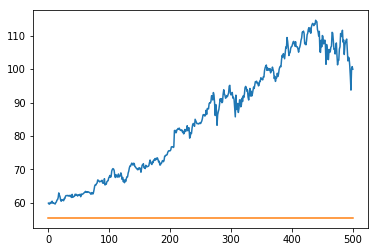

In [13]:
import matplotlib.pyplot as plt
plt.plot(y_test)
plt.plot(prd)
plt.show()